# Product Matching : Caso de Estudio - Mercado Libre

In [1]:
import requests
import pickle
import os
import re
import dill
import json
import pandas as pd
import numpy as np
import warnings
import nltk.corpus
import matplotlib.pyplot as plt
import kaleido
import plotly
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from collections import Counter
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from IPython.core.display import HTML
from nltk.probability import FreqDist
import sparse_dot_topn.sparse_dot_topn as ct
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from yellowbrick.cluster.elbow import kelbow_visualizer
from os.path import exists

(Clave presentacion) En este Challenge se quiso solucionar el problema de agrupacion de productos similares e identicos. Para esto primeramente busque temas respecto a clusterizacion de imagenes y texto. Tambien busque articulos que hablaran respecto a Product Matching que me dieran ideas de como podría atacar este problema de la manera mas optima posible. Como este es un problema no supervisado, no existe una metrica de evaluacion mas que la revision manual de los resultados que tenga sentido. Para esto utilize diferentes formas de graficar los resultados: Grafica de clusterizacion y Red de Emparejamientos. 

### Descargar Informacion

Miramos las diferentes categorias existentes que se pueden consultar.

In [4]:
cats = requests.get('https://api.mercadolibre.com/sites/MCO/categories')
cats.json()

[{'id': 'MCO1747', 'name': 'Accesorios para Vehículos'},
 {'id': 'MCO441917', 'name': 'Agro'},
 {'id': 'MCO1403', 'name': 'Alimentos y Bebidas'},
 {'id': 'MCO1071', 'name': 'Animales y Mascotas'},
 {'id': 'MCO1367', 'name': 'Antigüedades y Colecciones'},
 {'id': 'MCO1368', 'name': 'Arte, Papelería y Mercería'},
 {'id': 'MCO1384', 'name': 'Bebés'},
 {'id': 'MCO1246', 'name': 'Belleza y Cuidado Personal'},
 {'id': 'MCO40433', 'name': 'Boletas para Espectáculos'},
 {'id': 'MCO1039', 'name': 'Cámaras y Accesorios'},
 {'id': 'MCO1743', 'name': 'Carros, Motos y Otros'},
 {'id': 'MCO1051', 'name': 'Celulares y Teléfonos'},
 {'id': 'MCO1648', 'name': 'Computación'},
 {'id': 'MCO1144', 'name': 'Consolas y Videojuegos'},
 {'id': 'MCO172890', 'name': 'Construcción'},
 {'id': 'MCO1276', 'name': 'Deportes y Fitness'},
 {'id': 'MCO5726', 'name': 'Electrodomésticos'},
 {'id': 'MCO1000', 'name': 'Electrónica, Audio y Video'},
 {'id': 'MCO175794', 'name': 'Herramientas'},
 {'id': 'MCO1574', 'name': 'Ho

Creamos clase que se encargara de descargar la informacion de Mercado Libre el cual tiene las siguientes funciones:

1. **update_information**: Descargar informacion y añadir a la base de datos.
2. **save**: Guardar informacion del objeto como pickle.
3. **delete**: Eliminar informacion del objeto pickle.

In [5]:
class API():

    def __init__(self, country_code, product_id = None):
        """
        Initialization API class

        Parameters:

        :country_code (string): country code 
        :product_id (string): product_id of the country code
        :return (object): API Object.
        """
        if exists("API.pickle"):
            try:
                file_to_read = open("API.pickle", "rb")
                loaded_object = pickle.load(file_to_read)
                self.country_code = loaded_object.country_code
                self.product_id = loaded_object.product_id            
                self.database = loaded_object.database
                self.last_offset = loaded_object.last_offset
                file_to_read.close()
            except:
                print("No se pudo cargar archivo")
        else:             
            self.country_code = country_code
            self.product_id = product_id            
            self.database = pd.DataFrame()
            self.last_offset = 0

    def update_information(self, offset = None):
        """
        Download information/Update information

        Parameters:

        :offset (int): number benchmark to consider download the 50s items
        :return (DataFrame): Database with the downloaded information
        """
        if pd.isnull(offset):
            offset = self.last_offset
        try: 
            # -------------------
            # Request API
            # -------------------
            url = f'https://api.mercadolibre.com/sites/MCO/search?category={product_id}&offset={offset}'
            request = requests.get(url)
            items = request.json()
            items = items['results']

            # -------------------
            # Data Wrangling
            # -------------------
            database_dict = {}
            # Manera optima de añadir informacion a dataframe
            # link : https://stackoverflow.com/questions/27929472/improve-row-append-performance-on-pandas-dataframes
            for index, item in enumerate(items):
                database_dict[index] = {attribute : item[attribute] for attribute in item}
            
            database_offset = pd.DataFrame.from_dict(database_dict, "index")
            self.database = self.database.append(database_offset)
            self.last_offset += 50
        except:
            print(f"No se pudo correr informacion de offset={offset}")
    
    def save(self):
        """
        Save database

        Parameters:

        :return (pickel): API pickle object
        """
        file_to_store = open("API.pickle", "wb")
        pickle.dump(self, file_to_store)
        file_to_store.close()

    def delete(self):
        """
        Delete pickle API object

        Parameters:

        :return (pickle): Database with the downloaded information
        """
        if exists("API.pickle"):
            os.remove("API.pickle")

Esta celda correspondera a los diferentes paratos que recibe la clase API. Esta clase recibe tres parametros:

1. *country_code* : Codigo de pais segun API de mercado libre.
2. *run_download* : Determina si se quiere correr la descarga de informacion del producto.
3. *product_id* : Codigo del producto del pais obtenido previamente en el buscador de codigos de productos.

In [6]:
# ----------------------------
# API Initialization
# ----------------------------
run_download = False
country_code = "MCO"
# Celulares
product_id = "MCO1648"
if run_download:
    information = API(country_code, product_id)
    offset_list = [x*50 for x in range(1,20)]
    for offset_i in offset_list:
        information.update_information(offset_i)
    del offset_list
    information.save()
else:
    information = API(country_code, product_id)


### Text Clustering

Para poder determinar productos similares o identicos utilizando texto, debemos utilizar una metricas sobre estos textos y una forma de evaluarlos al compararlos con otros productos. Aunque la mayoría de palabras no tienen sinonimos, la mayoria de palabras si tienen algunos significados similares. Iphone 7 plus y Iphone 7+ tienen algunas similitudes y quisieramos poder capturar estas similitudes de alguna manera. Para esto utilizaremos la matriz TF-IDF (Matriz frecuencia - , Matriz inversa de documento-frecuencia) junto con el uso de n-gramas. Para este caso los documentos seran los titulos de los productos.

**N-Gramas**

Un N-grama es una subsecuencia de subtextos de un texto para NLP. Para Este caso utilizaremos N-gramas de caracteres es decir una subsecuencia de caracteres de una oracion. Por ejemplo el 3-grama de laptop es [lap, apt, pto, top], es util utilizar 2 y 3 N-gramas ya que en 2-3 enegramas se componen una silaba y esta nos puede ayudar a determinar similitudes entre palabras como por ejemplo Audifonos y Audio. Los dos comparten 2 3-ngramas [aud, udi]. Si $X=$ numero de caracteres de una oraciona, el numero de n-gramas de esa sentencia es 

$$Ngramas = X-(N-1).$$ 

Para el caso de laptop, note que $X=6$ y $N=3$, por lo tanto $Ngramas= 6-(3-1) =4$ que concuerda con nuestro caso.

**TD-IDF (Matriz frecuencia - , Matriz inversa de documento-frecuencia)**

La matriz frecuencia - matriz inversa de documento frecuencia (TD-IDF) como su nombre lo indica captura dos componente: 1) La frecuencia de la palabras(n-gramas) de un documento (titulo) 2)La frecuencia de un documento (titulo) en una palabra(n-grama). El primer componente evalua que tan importante una palabra es respecto a una coleccion de documentos(titulos). Por otra parte, el segundo componente captura de manera proporcional (logaritmica) el numero de veces qeu una palabra (n-grama) aparece. La matriz captura en cada casilla la multiplicacion del primer componente por el segundo componente. De manera mas especifica se calcula

$$TF(i,j) = \frac{\text{Frecuencia del termino i en el titulo j}}{\text{Numero de palabras totales en el titulo j}}$$

$$IDF(I) = log_2\left(\frac{\text{Numero total de titulos}}{\text{titulos con el termino i}}\right)$$

Finalmente la multipliacion de los dos da como resultado a

$$TD-IDF(i,j) = TF(i,j) \times IDF(i)$$

<div>
<center>
<img src="Images_jupyter/tf-idf.png" width="500"/>
<center>
</div>


Ahora es importante recordar que antes de procesar debemos limpiar los titulos con palabras que son recurrentes (para, de, etc) conocidas como stop-words. La matriz TF-IDF nos permite vectorizar cada titulo y con esto los modelos ya pueden entrar a jugar. Para esto consideramos la medida de similaridad coseno.

**Similaridad Coseno**

La similaridad coseno mide la similaridad (direccion) entre el embebimiento de textos. El embebimiento se denomina pasar la informacion de texto a un vector donde son comparables. De manera formal la similaridad coseno se define como

\begin{equation}
\operatorname{sim}(u, v)=\frac{u \cdot v}{\|u\|\|v\|}=\frac{\|u\|\|v\| \cdot cos(\theta)}{\|u\|\|v\|}=\frac{\sum_{i=1}^{n} u_{n} v_{n} \cdot cos(\theta)}{\sqrt{\sum_{i=1}^{n} u_{n}^{2}} \sqrt{\sum_{i=1}^{n} v_{n}^{2}}}
\end{equation}

<div>
<center>
<img src="Images_jupyter/cosine-similarity-vectors.original.jpg" width="800"/>
<center>
</div>

Comparando todos los posibles pares podemos entonces medir los vectores mas similares. Miremos una parte de la base de datos

In [7]:
information.database.head()

,id,site_id,title,seller,price,prices,sale_price,currency_id,available_quantity,sold_quantity,...,catalog_listing,use_thumbnail_id,offer_score,offer_share,match_score,winner_item_id,melicoin,discounts,order_backend,dir_image
0,MCO879619059,MCO,mouse vertical inalmbrico delux m618c black,"{'id': 549259885, 'permalink': None, 'registra...",59386,"{'id': 'MCO879619059', 'prices': [{'id': '4', ...",None,COP,44,302,...,True,True,None,None,None,None,None,None,1,d:\Codigos\Mercado_libre\Images\0_mouse vertic...
1,MCO656032406,MCO,switch tplink ls1005g serie litewave,"{'id': 655787052, 'permalink': None, 'registra...",61000,"{'id': 'MCO656032406', 'prices': [{'id': '9', ...",None,COP,11,85,...,True,True,None,None,None,None,None,None,2,d:\Codigos\Mercado_libre\Images\1_switch tplin...
2,MCO872040164,MCO,laptop dell inspiron 3505 negra 156 amd ryzen ...,"{'id': 549941369, 'permalink': None, 'registra...",2200000,"{'id': 'MCO872040164', 'prices': [{'id': '19',...",None,COP,18,6,...,True,True,None,None,None,None,None,None,3,d:\Codigos\Mercado_libre\Images\2_laptop dell ...
3,MCO560473979,MCO,sistema pos completo equipos gratis programa f...,"{'id': 76909393, 'permalink': None, 'registrat...",1389500,"{'id': 'MCO560473979', 'prices': [{'id': '9', ...",None,COP,250,250,...,NaN,False,None,None,None,None,None,None,4,d:\Codigos\Mercado_libre\Images\3_sistema pos ...
4,MCO657810711,MCO,tableta digitalizadora gaomon s620 black,"{'id': 144197738, 'permalink': None, 'registra...",151105,"{'id': 'MCO657810711', 'prices': [{'id': '30',...",None,COP,3,125,...,True,True,None,None,None,None,None,None,5,d:\Codigos\Mercado_libre\Images\4_tableta digi...


De la siguiente manera el siguiente objeto contiene las siguientes funciones:

1. **clean_text** : limpiar texto de puntuaciones y stop words.
2. **n_grams**: generar lista de n-gramas de cada titulo.
3. **awesome_cossim_top** : Generar las diferentes distancia de los diferentes vectores de cada titulo de TF-IDF.
4. **get_matches_df** : Generar los matches mas cercanos entre los titulos.
5. **elbow_score** : Graficar grilla de k-means.
6. **k_means_text**: Aplicar k-means con el mejor valor de la grilla.
7. **plot_network** : Graficar red de matches.
8. **group_network** : Retornar agrupaciones de la grafica de matches.

In [8]:
class Text_similarity():
    
    def __init__(self, items = None):
        """
        Initialization Text similarity object

        Parameters:

        :return (None):
        """
        if items is None: items = []
        self.l = items        
        self.elbow_value = None

    def clean_text(self, text):
        """
        Preprocessing cleaning corpus.

        Parameters:

        :text (string): text to be cleaned.
        :return (None):
        """
        # Link: https://monkeylearn.com/blog/text-cleaning/
        # Normalize text
        text = text.lower()
        # Remove unicode text
        text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
        # Remove stop words
        stop = stopwords.words('spanish')
        text = " ".join([word for word in text.split() if word not in (stop)])
        return text
        
    def ngrams(self, string, n=3):
        """
        Generate n-grams for a string.

        Parameters:

        :return (List): List with n-grams of the string.
        """
        ngrams = zip(*[string[i:] for i in range(n)])
        return [''.join(ngram) for ngram in ngrams]

    def awesome_cossim_top(self, tf_idf_matrix, tf_idf_matrix_transpose, ntop, lower_bound = 0):
        """
        Generate sparse matrix with cosine distance on TF-IDF Matrix

        Parameters:
        :tf_idf_matrix (Scipy Sparse Matrix): TF-IDF Matrix (sentence, ngram).
        :tf_idf_matrix_transpose (Scipy Sparse Matrix): TF-IDF Matrix Transpose (ngram, sentence).
        :ntop (int): top-n cosine similarity score.
        :lower_bound (int): if value of an element of C is less than lower_bound, the value will be replaced zero.
        
        :return (Csr_matrix):csr_matrix with top-n cosine similarity.
        """
        # force A and B as a CSR matrix.
        # If they have already been CSR, there is no overhead
        tf_idf_matrix = tf_idf_matrix.tocsr()
        tf_idf_matrix_transpose = tf_idf_matrix_transpose.tocsr()
        # Number of Sentences
        M, _ = tf_idf_matrix.shape
        # Number of ngrams
        _, N = tf_idf_matrix_transpose.shape
    
        idx_dtype = np.int32

        # Closest sentences
        nnz_max = M*ntop
    
        indptr = np.zeros(M+1, dtype = idx_dtype)
        indices = np.zeros(nnz_max, dtype = idx_dtype)
        data = np.zeros(nnz_max, dtype = tf_idf_matrix.dtype)

        # Link explanation:  https://medium.com/wbaa/https-medium-com-ingwbaa-boosting-selection-of-the-most-similar-entities-in-large-scale-datasets-450b3242e618
        # Link2 : https://towardsdatascience.com/finding-word-similarity-using-tf-idf-in-a-term-context-matrix-from-scratch-in-python-e423533a407
        ct.sparse_dot_topn(
            M, 
            N, 
            np.asarray(tf_idf_matrix.indptr, dtype = idx_dtype),
            np.asarray(tf_idf_matrix.indices, dtype = idx_dtype),
            tf_idf_matrix.data,
            np.asarray(tf_idf_matrix_transpose.indptr, dtype = idx_dtype),
            np.asarray(tf_idf_matrix_transpose.indices, dtype = idx_dtype),
            tf_idf_matrix_transpose.data,
            ntop,
            lower_bound,
            indptr, 
            indices, 
            data)
        return csr_matrix((data, indices, indptr),shape=(M, N))

    def get_matches_df(self, sparse_matrix, sentences_vector, prices, links, clustering_target, top = None):
        """
        Generate database of matches with their respectives prices and urls to check.

        Parameters:
        :sparse_matrix (Scipy Sparse Matrix): TF-IDF Matrix (sentence, ngram).
        :sentences_vector (DataFrame): Dataframe with titles.
        :prices (DataFrame): Dataframe with prices.
        :links (int):  Dataframe with URLS.
        
        :return (Dataframe ): database of matches with their respectives prices and urls to check.
        """
        non_zeros = sparse_matrix.nonzero()
        clustering_target = pd.DataFrame(clustering_target)
        # Number of setences
        sparserows = non_zeros[0]
        # Numebr of n-grams
        sparsecols = non_zeros[1]
        
        if top:
            nr_matches = top
        else:
            nr_matches = sparserows.size
        
        # Initialize Variables of the Dataframe
        left_side = np.empty([nr_matches], dtype=object)
        right_side = np.empty([nr_matches], dtype=object)
        similairity = np.zeros(nr_matches)
        prices_left = np.empty([nr_matches], dtype=object)
        links_left = np.empty([nr_matches], dtype=object)
        prices_right = np.empty([nr_matches], dtype=object)
        links_right = np.empty([nr_matches], dtype=object)
        clustering_left = np.empty([nr_matches], dtype=object)
        clustering_right = np.empty([nr_matches], dtype=object)

        # Star the matching with all possible matches
        for index in range(0, nr_matches):
            left_side[index] = sentences_vector.iloc[sparserows[index]]
            right_side[index] = sentences_vector.iloc[sparsecols[index]]
            similairity[index] = sparse_matrix.data[index]

            prices_left[index] = prices.iloc[sparserows[index]]
            links_left[index] = links.iloc[sparserows[index]]
            clustering_left[index] = clustering_target.iloc[sparserows[index]]

            prices_right[index] = prices.iloc[sparsecols[index]]
            links_right[index] = links.iloc[sparsecols[index]]
            clustering_right[index] = clustering_target.iloc[sparsecols[index]]


        return pd.DataFrame({'left_side': left_side,
                            'right_side': right_side,
                            'similarity': similairity,
                            'left price': prices_left,
                            'right price': prices_right,
                            'left URL': links_left,
                            'right URL': links_right,
                            })

    def elbow_score_kmeans(self, td_idf_matrix, limit = 20):
        """
        Plot and return elbow_score.

        Parameters:

        :tf_idf_matrix (Scipy Sparse Matrix): TF-IDF Matrix (sentence, ngram).
        :limit (int): limit to try for the elbow_score.
        :return (None):
        """
        warnings.filterwarnings('ignore')
        result = kelbow_visualizer(KMeans(random_state=4), tf_idf_matrix, k = (3, limit))
        self.elbow_value = result.elbow_value_
        return None
        
    def kmeans_text(self, tf_idf_matrix, titles, plot = True):
        """
        Plot k-means in 2 dimension reduction (SVD) and return target k-means clustering values.

        Parameters:

        :tf_idf_matrix (Scipy Sparse Matrix): TF-IDF Matrix (sentence, ngram).
        :titles (Dataframe): Column Dataframe that contains the titles.
        :plot (boolean): Option if wanted to be plot the k-means on dimension reduction.
        :return (Dataframe): K-mean cluestering target values.
        """
        kmeans = KMeans(n_clusters = self.elbow_value, random_state = 0).fit(tf_idf_matrix)
        cluster_target = kmeans.predict(tf_idf_matrix)
        svd = TruncatedSVD(n_components = 2)

        X_svd = svd.fit_transform(tf_idf_matrix)
        X_svd_df = pd.DataFrame(X_svd)
        X_svd_df.reset_index(drop = True, inplace = True)
        titles.reset_index(drop = True, inplace = True)

        X_svd_df['titles'] = titles

        if plot == True:
            fig = px.scatter(
                pd.DataFrame(X_svd_df), x = 0, y = 1,
                color = cluster_target,
                title = "Text Clustering",
                hover_data ={'titles':True}
            )

            fig.update_layout(
                xaxis_title="1 Dimension Reduction",
                yaxis_title="2 Dimension Reduction",
            )
            
            fig.show()
        return cluster_target

    def plot_network(self, G):
        """
        Plot newtork from graph network.

        Parameters:

        :G (Graph networknx): Graph of matches cosine similarity.
        :titles (Dataframe): Column Dataframe that contains the titles.
        :return (None):
        """
        # Generate the layout and set the 'pos' attribute
        # Link: https://plotly.com/python/network-graphs/
        pos = nx.drawing.layout.spring_layout(G)
        nx.set_node_attributes(G, pos, 'pos')

        # Create edges
        edge_x = []
        edge_y = []
        for edge in G.edges():
            x0, y0 = G.nodes[edge[0]]['pos']
            x1, y1 = G.nodes[edge[1]]['pos']
            edge_x.append(x0)
            edge_x.append(x1)
            edge_x.append(None)
            edge_y.append(y0)
            edge_y.append(y1)
            edge_y.append(None)

        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=0.5, color='#888'),
            hoverinfo='none',
            mode='lines')

        node_x = []
        node_y = []
        for node in G.nodes():
            x, y = G.nodes[node]['pos']
            node_x.append(x)
            node_y.append(y)

        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers',
            hoverinfo='text',
            marker=dict(
                showscale=True,
                # colorscale options
                #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
                #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
                #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
                colorscale='Earth',
                reversescale=True,
                color=[],
                size=10,
                colorbar=dict(
                    thickness=15,
                    title='Node Connections',
                    xanchor='left',
                    titleside='right'
                ),
                line_width=2))

        # Color Node Points
        node_adjacencies = []
        node_text = []
        for node, adjacencies in enumerate(G.adjacency()):
            node_adjacencies.append(len(adjacencies[1]))
            node_text.append(f'{adjacencies[0]} - # of connections: '+str(len(adjacencies[1])))

        node_trace.marker.color = node_adjacencies
        node_trace.text = node_text

        fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=f'Text Clustering Cosine-Similarity with TF IDF - Bound: {similarity_bound}' ,
                        #titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)),
                        )
        fig.show()
        return None

    def return_groups_network(self, G, matches_df):
        """
        Returns a dataframe that groups products based on the edge connectivity of network.

        Parameters:

        :G (Graph networknx): Graph of matches cosine similarity.
        :titles (Dataframe): Column Dataframe that contains the titles.
        :return (Dataframe): Dataframe with group number and group of titles.
        """
        dfgroup = pd.DataFrame()

        for n, i in enumerate(nx.connected_components(G)):
            arr = np.array(list(i))
            s = [node in matches_df['left_side'].tolist() for node in i]
            node_r = arr[s]
            df_r = pd.DataFrame({'Product Titles':[node_r]} ,
                                index=[n]) 
            dfgroup = pd.concat([dfgroup,df_r])

        dfgroup = dfgroup.rename_axis('Group Number').reset_index()
        return dfgroup

In [9]:
# --------------------------------------
# Text - Similarity Initialization
# --------------------------------------
similarity_bound = 0.8
text_similarity = Text_similarity()

# Clean text titles
information.database['title'] = information.database['title'].apply(text_similarity.clean_text)

# TD - IDF words
titles = information.database['title']
vectorizer = TfidfVectorizer(min_df = 1, analyzer = text_similarity.ngrams)
tf_idf_matrix = vectorizer.fit_transform(titles)

### EDA Analisis

(Clave presentacion) Inicialmente hice un analisis exploratorio del texto. Con este analisis pude determinar las palabras mas repetivas si es posible encontrar algunas similitudes como gb, portatil , gamer , etce en el juego. Con esto parto a trabajar en el algoritmo de clusterizacion de texto.

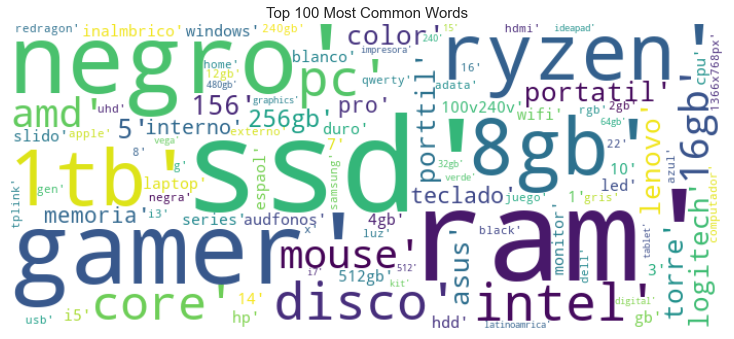

In [10]:
# --------------------------------------
# EDA - Exploratory Analysis NLP
# --------------------------------------
allwords = []
for index, wordlist in titles.iteritems():
    allwords += [word for word in wordlist.split(" ")]
    
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=700, height=300, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(10,5), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=15)
plt.tight_layout(pad=0)
plt.show()

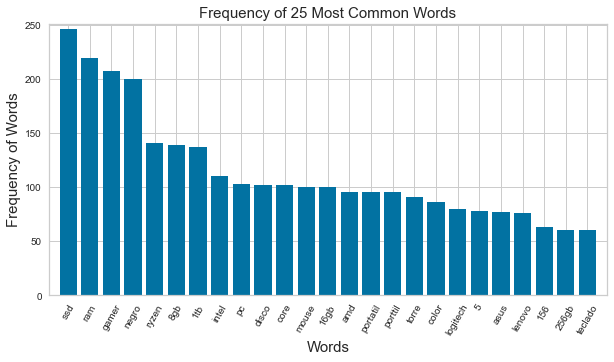

In [11]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(10,5))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=15)
plt.ylabel('Frequency of Words', fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(rotation=60, fontsize=10)
plt.title('Frequency of 25 Most Common Words', fontsize=15)
plt.show()

### Text Clustering

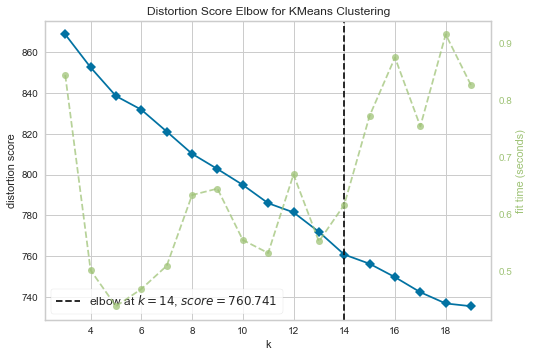

In [12]:
text_similarity.elbow_score_kmeans(tf_idf_matrix, limit = 20)

In [13]:
titles = information.database['title']
clustering_target = text_similarity.kmeans_text(tf_idf_matrix, titles)

In [14]:
prices = information.database['price']
links = information.database['permalink']
matches = text_similarity.awesome_cossim_top(tf_idf_matrix, tf_idf_matrix.transpose(), 10, similarity_bound)
matches_df = text_similarity.get_matches_df(matches, titles, prices, links, clustering_target)
matches_df = matches_df[matches_df['similarity'] < 0.99999] # For removing all exact matches
matches_df.head()

,left_side,right_side,similarity,left price,right price,left URL,right URL
2,switch tplink ls1005g serie litewave,switch tplink ls1005 serie litewave,0.908829,61000,48700,https://www.mercadolibre.com.co/switch-tp-link...,https://www.mercadolibre.com.co/switch-tp-link...
3,switch tplink ls1005g serie litewave,switch tplink ls1008 serie litewave,0.858817,61000,48514,https://www.mercadolibre.com.co/switch-tp-link...,https://www.mercadolibre.com.co/switch-tp-link...
5,laptop dell inspiron 3505 negra 156 amd ryzen ...,laptop dell inspiron 3505 negra 156 amd ryzen ...,0.868964,2200000,2061000,https://www.mercadolibre.com.co/laptop-dell-in...,https://www.mercadolibre.com.co/laptop-dell-in...
6,laptop dell inspiron 3505 negra 156 amd ryzen ...,laptop dell inspiron 3505 gris 156 amd ryzen 5...,0.861397,2200000,2183650,https://www.mercadolibre.com.co/laptop-dell-in...,https://www.mercadolibre.com.co/laptop-dell-in...
7,laptop dell inspiron 3505 negra 156 amd ryzen ...,laptop dell inspiron 3505 gris 156 amd ryzen 5...,0.854644,2200000,2182070,https://www.mercadolibre.com.co/laptop-dell-in...,https://www.mercadolibre.com.co/laptop-dell-in...


In [15]:
fig = px.histogram(matches_df, x="similarity")
fig.update_layout(bargap=0.2)
fig.show()

In [16]:
G = nx.from_pandas_edgelist(matches_df, source = "left_side", target = 'right_side')
text_similarity.plot_network(G)

In [17]:
group_network = text_similarity.return_groups_network(G, matches_df)
group_network

,Group Number,Product Titles
0,0,"[switch tplink ls1008 serie litewave, switch t..."
1,1,[laptop dell inspiron 3505 negra 156 amd ryzen...
2,2,[laptop hp 245 g7 negra 14 amd athlon 3020e 8g...
3,3,[memoria usb kingston datatraveler 100 g3 dt10...
4,4,[laptop dell inspiron 3501 plata 156 intel cor...
...,...,...
105,105,[portatil hp intel i3 10110u ssd 256gb ram 8gb...
106,106,[tableta digitalizadora wacom intuos s bluetoo...
107,107,[base gamer refrigerante porttil 5 niveles 1 v...
108,108,[disco duro externo toshiba 1tb tera estuche a...


##### Similaridad de Imagenes

Para poder hallar imagenes similares, podemos hacer comparaciones de los pixeles de cada imagen frente a otra imagen. Pero el problema es que esta medida es debil frente a cambios de perspectiva y de posicion. Para esto es util poder utilizar algoritmos que determinen caracteristicas inamovibles frente a cambios de perspectiva y de posicion.  Una de estas es mediante el embebimiendo usando una red convolucional (CNN) pre-entrenada. Las primeras capas convolucionales ( Convolucion y de Pooling) extrae caracteristicas de la imagen de menor a mayor escala. Luego las capas de perceptrones se encargan de mapear estas caracteristicas en un espacio y sacarle provecho. Finalmente con esta informacion usualmente se clasifica la imagen. Para nuestro caso solo utilizaremos la primera red de perceptrones para poder embeber las imagenes.

<div>
<center>
<img src="Images_jupyter/Convolutional.PNG" width="500"/>
<center>
</div>

Para nuestro caso utilizaremos  la reciente red convolucional EfficientNet (Google) la cual es rapida y precisa. Descargamos el modelo y con esto podremos determinar el embebimiento con la primera red no convolucional. Sin embargo antes de procesar las imagenes es importante normalizar y ajustar todas a un mismo tamaño de tal manera que el modelo pueda trabajar con las imagenes. Para este problema el modelo Efficien Net recibe una image de tamaño (224,224). Una vez mapeamos el embebimiento de las imagenes realizamos el mismos proceso realizado utilizando la similaridad coseno.

Si bien el proceso es el mismo, el tratamiento(Codigo) es diferente. Para esto construimos la clase Image_similarity. Su respectivas funciones son:

1. **process_image_dir** : Ajusta imagen a aspecto del modelo y normaliza pixeles.
2. **load_model**: Descarga modelo de tensorflow utilizando URL.
3. **embedding_image** : Embebimiento de las imagenes con el modelo cargado.
4. **generate_embedding_database** : Genera iterativamente sobre cada fila de imagenes, la base de datos de embebimiento.
5. **download_images**: Descargar imagenes en carpeta Images.
6. **elbow_score** : Graficar grilla de k-means.
7. **k_means_image**: Aplicar k-means con el mejor valor de la grilla.
8. **matches_cosine_image** : Realizar matches con la similaridad coseno.
9. **plot_network** : Graficar red de matches.
10. **group_network** : Retornar agrupaciones de la grafica de matches.

In [88]:
class Image_Similarity():

    def __init__(self, image_shape = None):
        """
        Initialization Text similarity object

        Parameters:

        :return (None):
        """
        if exists("Images.pickle"):
            try:
                file_to_read = open("Images.pickle", "rb")
                loaded_object = dill.load(file_to_read)
                self.image_shape =  loaded_object.image_shape
                self.model = loaded_object.model           
                self.database = loaded_object.database
                self.root_folder = os.path.dirname(os.path.abspath(os.curdir)) + "\Mercado_libre"
                self.elbow_value = None
                self.cosine_bound = None
                file_to_read.close()
            except:
                print("No se pudo cargar archivo")
        else:
            self.image_shape = image_shape 
            self.model = None  
            self.database = pd.DataFrame()
            self.root_folder = os.path.dirname(os.path.abspath(os.curdir)) + "\Mercado_libre"
            self.elbow_value = None
            self.cosine_bound = None
        
    def process_image_dir(self, image_dir):
        """
        Ajust image to image shape and normalize it.

        Parameters:

        :image_dir (Image): Image to be processed
        :return (image_dir): Processed image.
        """
        image = tf.keras.preprocessing.image.load_img(image_dir, target_size = self.image_shape )
        #image = np.stack((image,)*3, axis=-1)   
        image = np.array(image)/255.0 
        return image

    def load_model(self, model_url):
        """
        Load model from url link.

        Parameters:

        :model_url (string): Link to be downloaded model.
        :return (None):
        """
        layer = hub.KerasLayer(model_url, input_shape = self.image_shape+(3,))
        model = tf.keras.Sequential([layer])
        self.model = model
        return None    

    def embedding_image(self, image):
        """
        Embedding Image

        Parameters:

        :image (Image): Image to be embedded.
        :return (None):
        """
        try: 
            embedding = self.model.predict(image[np.newaxis, ...])
            embedding_np = np.array(embedding)
            flattended_feature = embedding_np.flatten()
            return flattended_feature
        except:
            print("No a cargado modelo")

    def generate_embedding_database(self, row):
        """
        Embedding Image

        Parameters:

        :image (Image): Image to be embedded.
        :return (None):
        """
        image_dir = row['dir_image']
        image = image_similarity.process_image_dir(image_dir)
        embedding_image = image_similarity.embedding_image(image)

        
        database_dict = {}
        # Manera optima de añadir informacion a dataframe
        # link : https://stackoverflow.com/questions/27929472/improve-row-append-performance-on-pandas-dataframes
        database_dict[row.name] = {index :embedding_image[index] for index in range(len(embedding_image))}
        database_dict[row.name].update({"title" : row['title']})
        database_dict[row.name].update({"url" : row['permalink']})
        database_dict[row.name].update({"price" : row['price']})        
        database_offset = pd.DataFrame.from_dict(database_dict, "index")
        self.database = self.database.append(database_offset)
        return 

    def save(self):
        """
        Save database

        Parameters:

        :return (pickle): Image pickle object.
        """
        with open("Images.pickle", "wb") as f:
            self.model = None
            dill.dump(self, f)

    def delete(self):
        """
        Delete pickle Image object

        Parameters:

        :return (pickle): Database with the downloaded information
        """
        if exists("Images.pickle"):
            os.remove("Images.pickle")

    def download_images(self, row):
        """
        Download images from link taking in account the row of DataFrame of Mercado Libre.

        Parameters:

        :row (Dataframe row): row DataFrame
        :return (None):
        """
        images_folder = self.root_folder + "\Images"
        filename = os.path.join(images_folder,
                                '_'.join([str(row.name),
                                            row['title']]))
        filename += '.jpg'

        # create folder if it doesn't exist
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        url = row['thumbnail']
        print(f"Downloading {url} to {filename}")
        r = requests.get(url, allow_redirects=True)
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename

    def elbow_score_kmeans(self, embedding_data, limit = 20):
        """
        Plot and return elbow_score.

        Parameters:

        :embedding_data (DataFrame): Datafram that contains the embedding of Images.
        :limit (int): limit to try for the elbow_score.
        :return (None):
        """
        warnings.filterwarnings('ignore')
        result = kelbow_visualizer(KMeans(random_state=4), embedding_data, k = (3, limit))
        self.elbow_value = result.elbow_value_
        return None 

    def kmeans_image(self, database_notitle):
        """
        Plot k-means in 2 dimension reduction (SVD) and return target k-means clustering values.

        Parameters:

        :database_notitle (DataFrame): Dataframe where each column correspond to an embedding variable.
        :titles (Dataframe): Column Dataframe that contains the titles.
        :plot (boolean): Option if wanted to be plot the k-means on dimension reduction.
        :return (Dataframe): K-mean cluestering target values.
        """
        kmeans = KMeans(n_clusters = self.elbow_value, random_state = 0).fit(database_notitle)
        cluster_target = kmeans.predict(database_notitle)
        svd = TruncatedSVD(n_components = 2)

        X_svd = svd.fit_transform(database_notitle)
        X_svd_df = pd.DataFrame(X_svd)
        X_svd_df.reset_index(drop = True, inplace = True)
        titles.reset_index(drop = True, inplace = True)

        X_svd_df['titles'] = titles


        fig = px.scatter(
            pd.DataFrame(X_svd_df), x = 0, y = 1,
            color = cluster_target,
            title = "Image Clustering",
            hover_data ={'titles':True}
        )

        fig.update_layout(
            xaxis_title="1 Dimension Reduction",
            yaxis_title="2 Dimension Reduction",
        )

        fig.show()       
        return None

    def matches_cosine_image(self, matrix_similarity, cosine_bound = 0.8):
        """
        Return a database with 

        Parameters:

        :database_notitle (DataFrame): Dataframe where each column correspond to an embedding variable.
        :titles (Dataframe): Column Dataframe that contains the titles.
        :plot (boolean): Option if wanted to be plot the k-means on dimension reduction.
        :return (Dataframe): K-mean cluestering target values.
        """
        # Link: 
        matrix_similarity[np.tril_indices(matrix_similarity.shape[0])] = -2    
        top_cosine_similarity = pd.DataFrame()
        k = matrix_similarity.shape[0]

        # Get top k similarities and pair in ascending order
        top_cosine_similarity = pd.DataFrame()

        # moving k in each window of top indexes
        k = matrix_similarity.shape[0]
        self.cosine_bound = cosine_bound

        # Each batch will contain 100 rows
        batch = len(matrix_similarity.ravel())/100

        for i in range(1, int(batch)):
            np.arange(0, len(matrix_similarity.ravel()), 100)
            # Get top k similarities and pair in ascending order
            # This code convert to flatten, sort it by value and returns the top
            top_k_indexes = np.unravel_index(np.argsort(matrix_similarity.ravel())[-k*i:], matrix_similarity.shape)

            # Create row values
            for index in range(k):
                index_left = top_k_indexes[0][index]
                index_right = top_k_indexes[1][index]
                value = {
                    "left_title": image_similarity.database.iloc[index_left]["title"],
                    "right_title": image_similarity.database.iloc[index_right]["title"],
                    "cosine_similarity" : matrix_similarity[index_left, index_right],
                    "left_url": image_similarity.database.iloc[index_left]["url"],
                    "right_url": image_similarity.database.iloc[index_right]["url"],
                    "left_price": image_similarity.database.iloc[index_left]["price"],
                    "right_price": image_similarity.database.iloc[index_right]["price"],
                    }
                if matrix_similarity[index_left, index_right] < cosine_bound:
                    break
                top_cosine_similarity = top_cosine_similarity.append(value, ignore_index = True)
            else:
                top_cosine_similarity = top_cosine_similarity.append(value, ignore_index = True)
            break
        return top_cosine_similarity

    def plot_network(self, G):
            """
            Plot newtork from graph network.

            Parameters:

            :G (Graph networknx): Graph of matches cosine similarity.
            :titles (Dataframe): Column Dataframe that contains the titles.
            :return (None):
            """
            # Generate the layout and set the 'pos' attribute
            pos = nx.drawing.layout.spring_layout(G)
            nx.set_node_attributes(G, pos, 'pos')

            edge_x = []
            edge_y = []
            for edge in G.edges():
                x0, y0 = G.nodes[edge[0]]['pos']
                x1, y1 = G.nodes[edge[1]]['pos']
                edge_x.append(x0)
                edge_x.append(x1)
                edge_x.append(None)
                edge_y.append(y0)
                edge_y.append(y1)
                edge_y.append(None)

            edge_trace = go.Scatter(
                x=edge_x, y=edge_y,
                line=dict(width=0.5, color='#888'),
                hoverinfo='none',
                mode='lines')

            node_x = []
            node_y = []
            for node in G.nodes():
                x, y = G.nodes[node]['pos']
                node_x.append(x)
                node_y.append(y)

            node_trace = go.Scatter(
                x=node_x, y=node_y,
                mode='markers',
                hoverinfo='text',
                marker=dict(
                    showscale=True,
                    # colorscale options
                    #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
                    #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
                    #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
                    colorscale='Earth',
                    reversescale=True,
                    color=[],
                    size=10,
                    colorbar=dict(
                        thickness=15,
                        title='Node Connections',
                        xanchor='left',
                        titleside='right'
                    ),
                    line_width=2))

            node_adjacencies = []
            node_text = []
            for node, adjacencies in enumerate(G.adjacency()):
                node_adjacencies.append(len(adjacencies[1]))
                node_text.append(f'{adjacencies[0]} - # of connections: '+str(len(adjacencies[1])))

            node_trace.marker.color = node_adjacencies
            node_trace.text = node_text

            fig = go.Figure(data=[edge_trace, node_trace],
                        layout=go.Layout(
                            title=f'Image Cosine-Similarity with - Bound: {self.cosine_bound}' ,
                            #titlefont_size=16,
                            showlegend=False,
                            hovermode='closest',
                            margin=dict(b=20,l=5,r=5,t=40),
                            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)),
                            )
            fig.show()
            return None

    def return_groups_network(self, G, matches_df):
        """
        Returns a dataframe that groups products based on the edge connectivity of network.

        Parameters:

        :G (Graph networknx): Graph of matches cosine similarity.
        :titles (Dataframe): Column Dataframe that contains the titles.
        :return (Dataframe): Dataframe with group number and group of titles.
        """
        dfgroup = pd.DataFrame()

        for n, i in enumerate(nx.connected_components(G)):
            arr = np.array(list(i))
            s = [node in matches_df['left_title'].tolist() for node in i]
            node_r = arr[s]
            df_r = pd.DataFrame({'Product Titles':[node_r]} ,
                                index=[n]) 
            dfgroup = pd.concat([dfgroup,df_r])

        dfgroup = dfgroup.rename_axis('Group Number').reset_index()
        return dfgroup

In [89]:
# --------------------------------------
# Parameters - Image Similarity
# --------------------------------------
model_url = "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2"
IMAGE_SHAPE = (224, 224)
run_download_image = False
run_embedding_database = False
cosine_bound = 0.8

image_similarity = Image_Similarity(IMAGE_SHAPE)
image_similarity.load_model(model_url)

if run_download_image:
    information.database['dir_image'] = information.database.apply(lambda x: image_similarity.download_images(x), axis = 1)

if run_embedding_database:
    information.database.apply(lambda x: image_similarity.generate_embedding_database(x), axis = 1)    

# Save object to avoid re-running it again
# image_similarity.save()

In [90]:
database_notitle = image_similarity.database.drop(columns = ['title', 'url' , 'price'])
matrix_similarity = cosine_similarity(database_notitle)

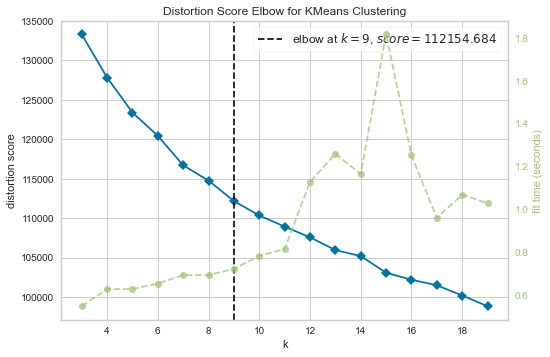

In [91]:
image_similarity.elbow_score_kmeans(database_notitle, limit = 20)

In [92]:
image_similarity.kmeans_image(database_notitle)

In [93]:
top_cosine_similarity = image_similarity.matches_cosine_image(matrix_similarity, cosine_bound)
top_cosine_similarity

,left_title,right_title,cosine_similarity,left_url,right_url,left_price,right_price
0,lenovo legin ryzen 7 5800h rtx 3050ti 16g 512 ...,lenovo legion pro ryzen 7 5800h rtx 3070 2k 1t...,0.841700,https://articulo.mercadolibre.com.co/MCO-64948...,https://articulo.mercadolibre.com.co/MCO-86276...,5299999.0,7799999.0
1,kit teclado mouse inalmbrico logitech mk220 es...,teclado gamer redragon vata pro k580rgbpro qwe...,0.841708,https://www.mercadolibre.com.co/kit-de-teclado...,https://www.mercadolibre.com.co/teclado-gamer-...,86900.0,284900.0
2,kit teclado mouse inalmbrico logitech mk220 es...,teclado gamer redragon vata pro k580rgbpro qwe...,0.841708,https://www.mercadolibre.com.co/kit-de-teclado...,https://www.mercadolibre.com.co/teclado-gamer-...,85887.0,284900.0
3,teclado gamer nibio impact mk500 qwerty espaol...,teclado gamer bluetooth logitech serie g g915 ...,0.841709,https://www.mercadolibre.com.co/teclado-gamer-...,https://www.mercadolibre.com.co/teclado-gamer-...,169900.0,875900.0
4,portatil lenovo 315ada05 amd ryzen 5 3500u8gb2...,porttil ideapad 5 pro intel core i7 16gb 512gb...,0.841733,https://articulo.mercadolibre.com.co/MCO-60575...,https://articulo.mercadolibre.com.co/MCO-80070...,2339900.0,4099900.0
...,...,...,...,...,...,...,...
946,torre cpu intel core i7 12700 uhd 770 1tb 16gb pc,torre cpu gamer core i9 11900 gpu 2gb hdmi 1tb...,1.000000,https://articulo.mercadolibre.com.co/MCO-86499...,https://articulo.mercadolibre.com.co/MCO-65777...,3649900.0,4749900.0
947,ereader kindle paperwhite 10 gen 32gb azul pan...,ereader kindle paperwhite 10 gen 8gb azul pant...,1.000000,https://www.mercadolibre.com.co/e-reader-kindl...,https://www.mercadolibre.com.co/e-reader-kindl...,543184.0,446185.0
948,torre cpu intel core i7 12700 uhd 770 1tb 16gb pc,torre cpu gamer core i9 11900 gpu 2gb hdmi 1tb...,1.000000,https://articulo.mercadolibre.com.co/MCO-86499...,https://articulo.mercadolibre.com.co/MCO-65777...,3649900.0,5149900.0
949,torre cpu intel core i9 12900 uhd 770 1tb 16gb pc,torre cpu gamer core i9 11900 gpu 2gb hdmi 1tb...,1.000000,https://articulo.mercadolibre.com.co/MCO-86481...,https://articulo.mercadolibre.com.co/MCO-65777...,4849900.0,4749900.0


In [94]:
G = nx.from_pandas_edgelist(top_cosine_similarity, source = "left_title", target = 'right_title')
image_similarity.plot_network(G)

In [95]:
group_network = image_similarity.return_groups_network(G, top_cosine_similarity)
group_network

,Group Number,Product Titles
0,0,[lenovo legin ryzen 7 5800h rtx 3050ti 16g 512...
1,1,[kit teclado mouse inalmbrico logitech mk470 e...
2,2,[portatil hp 15eh0002la r54500u 8gb 512ssd 15 ...
3,3,[mouse juego logitech g series hero g502 negro...
4,4,[pc computador gamer amd ryzen 7 5700g ssd 480...
...,...,...
111,111,[portatil asus x543uagq2087 core i3 1tb 8gb 15...
112,112,[torre cpu intel core i3 10100 uhd 630 1tb 8gb...
113,113,[laptop lenovo ideapad 14igl05 ice blue 14 int...
114,114,[tablet samsung galaxy tab a7 lite smt220 87 6...


### Conclusion y proximos pasos

Con este proyecto podemos determinar que el embebimiento de texto inicialmente es una buena aproximación para solucionar este problema. El algoritmo de K-means como el algoritmo de similaridad de coseno da muy buenos resultados comprobados visualmente. De esta manera podemos determinar agrupaciones identicas con la similaridad de texto y con la similaridad de imagen podemos determinar agrupaciones mas generales. Los proximos pasos quedarian en crear un puntaje de emparejamiento que tenga en cuenta estas dos aproximaciones asi como sobre mas variables (peso, tamaño, etc). Asi como considerar differentes modelos para embeber y obtener mejores resultados. 

In [96]:
# ----------------------------
# Test outputs 
# ----------------------------

# clean texts
ejem_text = "Laptop Hp 245 G7 Negra 14 , Amd 3020e  8gb De Ram 1tb Hdd, Amd Radeon Rx Vega 3 1366x768px Windows 10 Home"
ejem_text = text_similarity.clean_text(ejem_text)
print(f"Clean Text {ejem_text}")
ejem_text_ngram = text_similarity.ngrams(ejem_text, n =3)
print(f"N-gram Text {ejem_text_ngram}")



Clean Text laptop hp 245 g7 negra 14 amd 3020e 8gb ram 1tb hdd amd radeon rx vega 3 1366x768px windows 10 home
N-gram Text ['lap', 'apt', 'pto', 'top', 'op ', 'p h', ' hp', 'hp ', 'p 2', ' 24', '245', '45 ', '5 g', ' g7', 'g7 ', '7 n', ' ne', 'neg', 'egr', 'gra', 'ra ', 'a 1', ' 14', '14 ', '4 a', ' am', 'amd', 'md ', 'd 3', ' 30', '302', '020', '20e', '0e ', 'e 8', ' 8g', '8gb', 'gb ', 'b r', ' ra', 'ram', 'am ', 'm 1', ' 1t', '1tb', 'tb ', 'b h', ' hd', 'hdd', 'dd ', 'd a', ' am', 'amd', 'md ', 'd r', ' ra', 'rad', 'ade', 'deo', 'eon', 'on ', 'n r', ' rx', 'rx ', 'x v', ' ve', 'veg', 'ega', 'ga ', 'a 3', ' 3 ', '3 1', ' 13', '136', '366', '66x', '6x7', 'x76', '768', '68p', '8px', 'px ', 'x w', ' wi', 'win', 'ind', 'ndo', 'dow', 'ows', 'ws ', 's 1', ' 10', '10 ', '0 h', ' ho', 'hom', 'ome']


## Referencias:

* https://towardsdatascience.com/surprisingly-effective-way-to-name-matching-in-python-1a67328e670e
* https://www.jcchouinard.com/wp-content/uploads/2021/10/image-4.png
*¨https://www.activeloop.ai/resources/generate-image-embeddings-using-a-pre-trained-cnn-and-store-them-in-hub/
